In [1]:
# Parameters
input_filename = "./brain_tumor_dataset/yes/Y1.JPG"
output_filename = "Y1.JPG"
should_load_model = True

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
image = cv2.imread(input_filename)

In [4]:
def remove_boundaries(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(cnt) for cnt in contours]
    max_area_index = np.argmax(areas)
    largest_contour = contours[max_area_index]

    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image

In [5]:
def scale(image):
    
    height = 600
    width = 600

    dim = (width, height)

    return cv2.resize(image, dim)

In [6]:
def remove_noise(image):
    return cv2.medianBlur(image, 5)

In [7]:
def sharpen_image(image):
    kernel_sharpening = np.array([[0,-1,0], 
                                  [-1, 5,-1],
                                  [0,-1,0]])
    return cv2.filter2D(image, -1, kernel_sharpening)

In [8]:
def apply_pipeline(image):

    boundary_less = remove_boundaries(image)
    scaled_image = scale(boundary_less)
    noiseless = remove_noise(scaled_image)
    sharpened = sharpen_image(noiseless)
    return sharpened

In [9]:
yes = []
no = []
all_images = []

yes_path = "./brain_tumor_dataset/yes/"
no_path = "./brain_tumor_dataset/no/"

In [10]:
temp_yes = []
temp_no = []

count = 0
for filename in os.listdir(yes_path):
    image = cv2.imread(yes_path + filename)
    temp_yes.append((image, 1))
    count += 1
    if count == 3:
        break

count = 0
for filename in os.listdir(no_path):
    image = cv2.imread(no_path + filename)
    temp_no.append((image, 0))
    count += 1
    if count == 3:
        break

temp_all = temp_yes + temp_no
data = [i[0] for i in temp_all]
labels = [i[1] for i in temp_all]

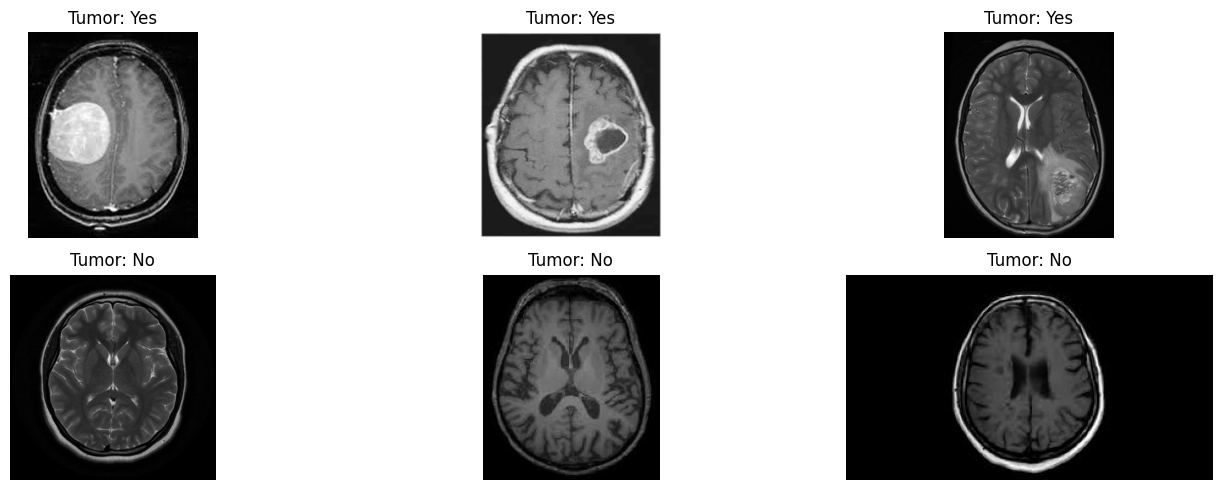

In [11]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(temp_yes[i][0])  
    plt.title("Tumor: Yes")  
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(temp_no[i][0])  
    plt.title("Tumor: No")  
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
temp_all = []
temp_image_path = "./brain_tumor_dataset/yes/Y1.jpg"
temp_image = cv2.imread(temp_image_path)
temp_all.append((temp_image, "Original Image"))

# Applying transformations
boundary_less = remove_boundaries(temp_image)
scaled_image = scale(boundary_less)
noiseless = remove_noise(scaled_image)
sharpened = sharpen_image(noiseless)

temp_all.append((boundary_less, "Boundary Less Image"))
temp_all.append((scaled_image, "Scaled Image"))
temp_all.append((noiseless, "Noiseless Image"))
temp_all.append((sharpened, "Shaprnened Image"))

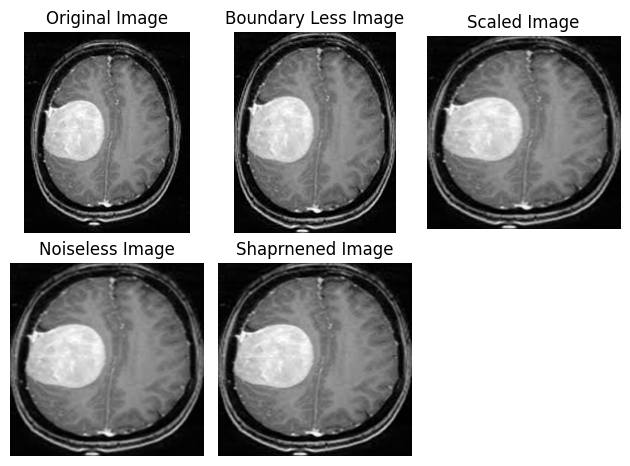

In [13]:
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.imshow(temp_all[i][0])  
    plt.title(temp_all[i][1])  
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Applying pre processing on Yes labelled images
for file_name in os.listdir(yes_path):
    img = cv2.imread(yes_path + file_name)
    yes.append((apply_pipeline(img), 1))

# Applying pre processing on No labelled images
for file_name in os.listdir(no_path):
    img = cv2.imread(no_path + file_name)
    no.append((apply_pipeline(img), 0))

all_images = yes + no

data = np.array([i[0] for i in all_images])
labels = np.array([i[1] for i in all_images])

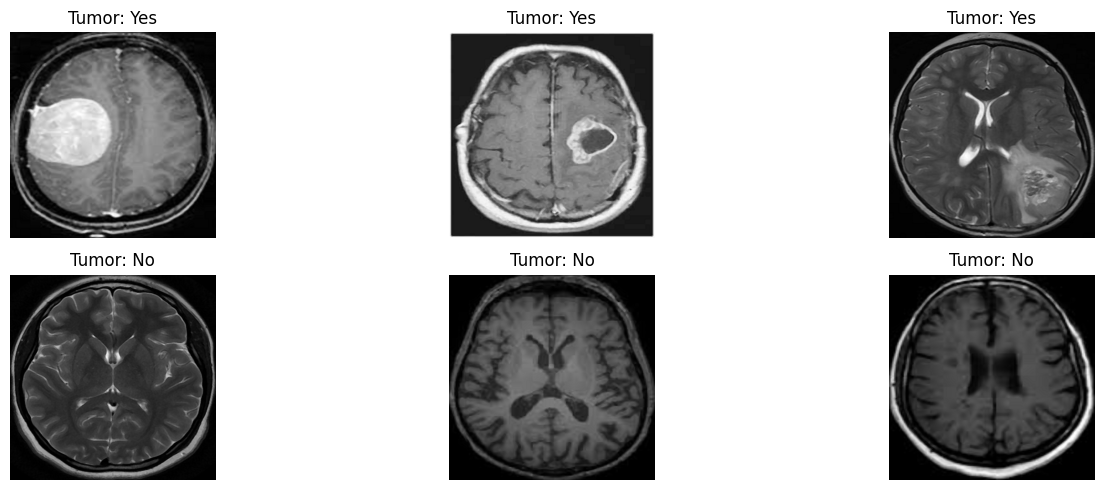

In [15]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(yes[i][0])  
    plt.title("Tumor: Yes")  
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no[i][0])  
    plt.title("Tumor: No")  
    plt.axis('off')

plt.tight_layout()
plt.show()

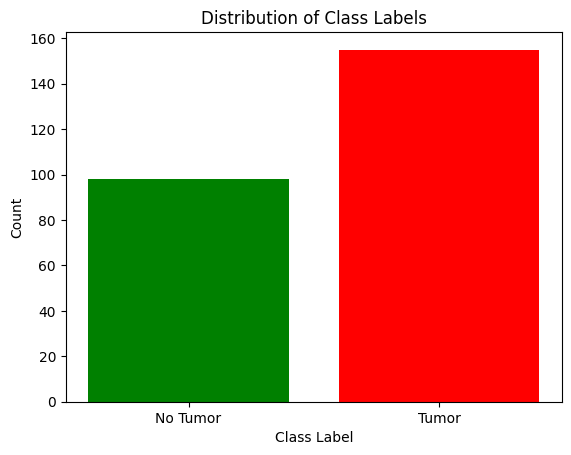

In [16]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['green', 'red'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [17]:
if should_load_model:
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(600, 600, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
    print(model.summary())  

c:\Users\Rida Abid\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 598, 598, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 299, 299, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 297, 297, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 148, 148, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 146, 146, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 73, 73, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 682112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 682112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    87,310,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,403,841 (333.42 MB)

 Trainable params: 87,403,841 (333.42 MB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
test_data, val_images, test_labels, val_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=42)

print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (202, 600, 600, 3)
Train labels shape: (202,)
Validation data shape: (26, 600, 600, 3)
Validation labels shape: (26,)
Test data shape: (25, 600, 600, 3)
Test labels shape: (25,)


In [19]:
print(np.max(train_data))
print(np.min(train_data))

train_images=train_data/255
test_images=test_data/255
val_images=val_images/255
print(np.max(train_images))
print(np.min(train_images))

255
0
1.0
0.0


In [20]:
if should_load_model:
    epochs = 50 
    batch_size = 16 

    early_stopping = EarlyStopping(patience=5, monitor='val_loss')

    history = model.fit(train_data, 
                        train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(val_images, val_labels),
                    callbacks=[early_stopping])

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.4502 - loss: 86.8099 - val_accuracy: 0.5385 - val_loss: 0.6840
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.6149 - loss: 31.1181 - val_accuracy: 0.6538 - val_loss: 0.6784
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.6963 - loss: 7.9514 - val_accuracy: 0.5769 - val_loss: 0.6852
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7735 - loss: 1.7661 - val_accuracy: 0.7308 - val_loss: 0.6901
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.8051 - loss: 0.4638 - val_accuracy: 0.7308 - val_loss: 0.6899
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.8332 - loss: 0.3533 - val_accuracy: 0.8462 - val_loss: 0.6888
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9367 - loss: 0.2099 - val_accuracy: 0.8462 - val_loss: 0.6884


In [21]:
if should_load_model:
    model.save("./cnn.h5")

In [22]:
if not should_load_model:
    model = load_model("./cnn.h5")

In [23]:
loss, accuracy = model.evaluate(test_images, test_labels)

# Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.7600 - loss: 0.6907
Test Loss: 0.6907105445861816
Test Accuracy: 0.7599999904632568


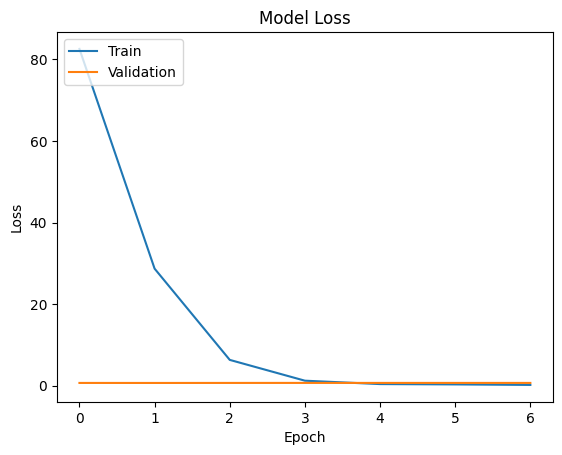

In [24]:
if should_load_model:
    # Plotting the training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


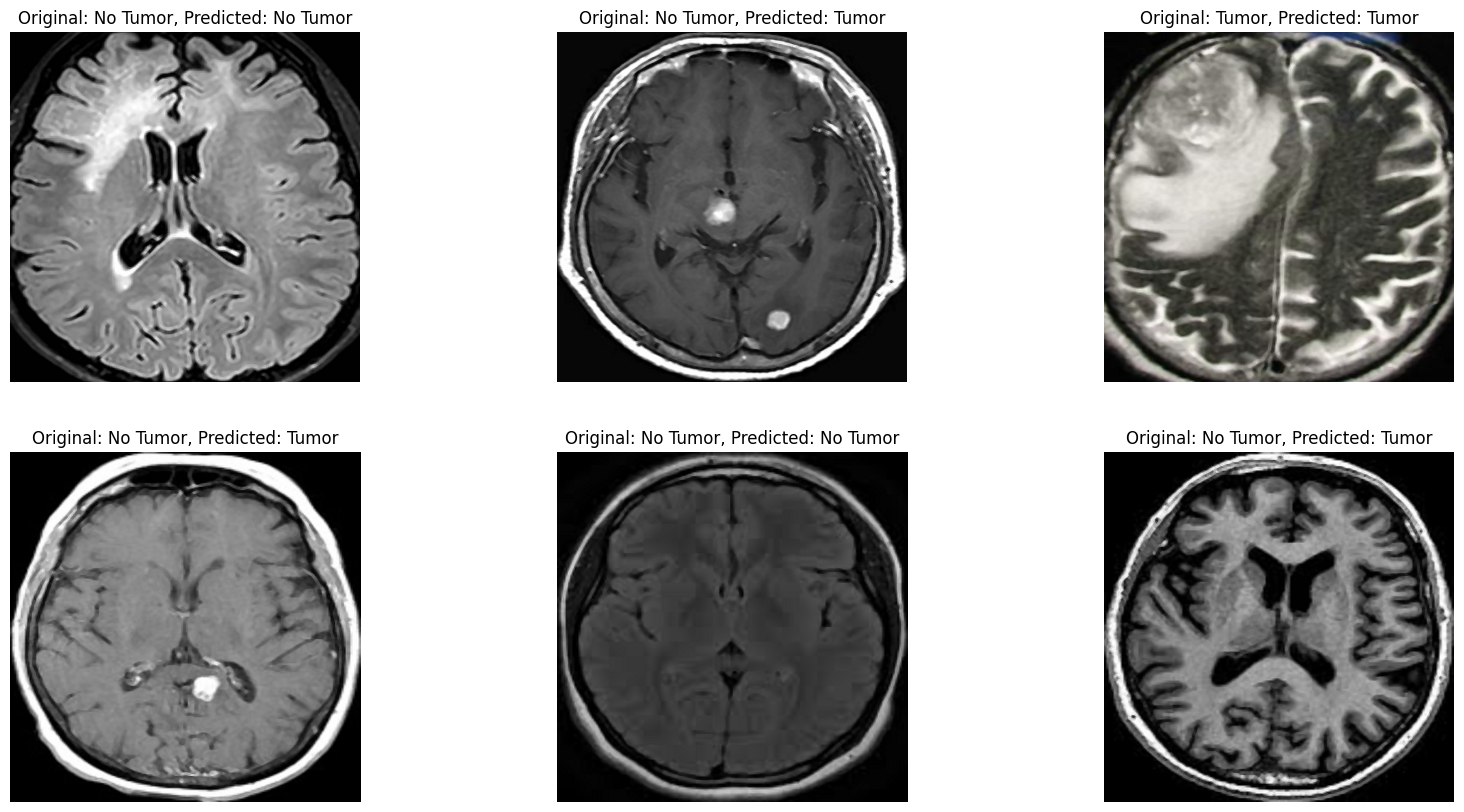

In [25]:
zipped = zip(test_data, test_labels)

count = 0
plt.figure(figsize=(20, 10))
for a, b in zipped:
    plt.subplot(2, 3, count + 1)
    plt.axis("off")
    org = "Tumor" if b == 1 else "No Tumor"
    pred = "Tumor" if model.predict(np.array([a/255]))[0][0] > 0.5 else "No Tumor"
    plt.title(f"Original: {org}, Predicted: {pred}")
    plt.imshow(a)
    if count == 5:
        break
    count += 1

plt.show()

In [26]:
# Get the predicted labels
predicted_labels = [1 if model.predict(np.array([image/255]))[0][0] > 0.5 else 0 for image in test_data]

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Confusion Matrix:
[[ 6  6]
 [ 